In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
## Onehot encoding
def ryan_onehot(labels):
    labels = labels.as_matrix()
    temp = []
    for val in labels:
        if val not in temp:
            temp.append(val)
    temp.sort()
    
    result = np.zeros(shape=(len(labels),len(temp)))
    for key, val in enumerate(labels):
        result[key][temp.index(val)] = 1
    return result

## Weight init
def ryan_initweight(topo):
    np.random.seed(1)
    params = {}
    relu_init = 2/math.sqrt(400+10)
    tanh_init = math.sqrt(2)/math.sqrt(400+10)
    for i in range(1, len(topo)):
        params['W' + str(i)] = tanh_init*np.random.randn(topo[i], topo[i-1])
        params['b' + str(i)] = 0.01*np.zeros(shape=(topo[i], 1))
    return params

## Forward pass
def ryan_forward(X, params, predict=0):
    caches = []
    A = X
    D = 0
    for i in range(int(len(params)/2)):
        if predict == 0:
            Z, cache = ryan_cal_Z(params['W' + str(i+1)], params['b' + str(i+1)], A)
            if i == int(len(params)/2) - 1:
                A = ryan_sigmoid(Z)
                cache.append(0)
            else:
                A = ryan_tanh(Z)
                A, D = ryan_drop_out(A)
                cache.append(D)
            caches.append(cache)
        else:
            Z,_ = ryan_cal_Z(params['W' + str(i+1)], params['b' + str(i+1)], A)
            if i == int(len(params)/2) - 1:
                A = ryan_sigmoid(Z)
            else:
                A = ryan_tanh(Z)
    return A, caches

def ryan_cal_Z(W,b,A):
    Z = np.dot(W, A) + b
    cache = [A,W,b,Z]
    return Z, cache

## Backward pass
def ryan_backward(lastA, Y, caches):
    m = Y.shape[1]
    L = len(caches)
    grads = {}
    temp1, temp2, temp3 = 0.0, 0.0, 0.0
    temp1 = np.divide(1 - Y, 1 - lastA) - np.divide(Y, lastA)
    for i in reversed(range(L)):
        current_cache = caches[i]
        if i != L-1:
            temp1 = ryan_drop_out_back(temp1, current_cache[-1])
            dZ = ryan_tanh_back(temp1, current_cache[-2])
        else:
            dZ = ryan_sigmoid_back(temp1, current_cache[-2])
        
        temp1, temp2, temp3 = ryan_cal_grads(dZ, current_cache[0:-2])
        grads["dA" + str(i + 1)] = temp1
        grads["dW" + str(i + 1)] = temp2
        grads["db" + str(i + 1)] = temp3
        
    return grads

def ryan_cal_grads(dZ, cache):
    m = cache[0].shape[1]
    dW = np.dot(dZ, cache[0].T)/m
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dA = np.dot(cache[1].T, dZ)
    return dA, dW, db

## Gradient descent
def ryan_gd(X, Y, topo, learning_rate=0.01, iters=5000, batch_size=50):
    params = ryan_initweight(topo)
    costs = []
    for i in range(iters):
#         if i == 500: learning_rate = 0.003
        for j in xrange(0, X.shape[1], batch_size):
            lastA, caches = ryan_forward(X.iloc[:,j:j+batch_size], params)
            cost = ryan_cost_func(lastA, Y[:,j:j+batch_size])
            grads = ryan_backward(lastA, Y[:,j:j+batch_size], caches)
            params = ryan_update_params(params, grads, learning_rate)

        if i % 100 == 0:
            _,_, accuracy1 = ryan_softmax_predict(X_train, Y_train1, params)
            _,_, accuracy = ryan_softmax_predict(X_test, Y_test, params)
            print('Accuracy: ' + str(accuracy) + ' === Cost: ' + str(cost))
            print(accuracy1)
            costs.append(cost)
            
    ryan_plotCost(costs)
    return params

def ryan_cost_func(lastA, Y):
    t1 = np.multiply(Y, np.log(lastA))
    t2 = np.multiply(1.0 - Y, np.log(1.0 - lastA))
    print(t1.shape)
    print(t2.shape)
    cost = (-1.0/Y.shape[1]) * np.sum(t1 + t2)
    return cost

def ryan_update_params(params, grads, learning_rate):
    for i in range(int(len(params)/2)):
        params["W" + str(i + 1)] = params["W" + str(i + 1)] - learning_rate * grads["dW" + str(i + 1)]
        params["b" + str(i + 1)] = params["b" + str(i + 1)] - learning_rate * grads["db" + str(i + 1)]
    return params

## Dropout regularization
def ryan_drop_out(A):
    keep_prob= 0.2
    D = np.random.rand(A.shape[0],A.shape[1])
    D = np.where(D < keep_prob, 1, 0)
    A = np.multiply(D, A)
    A = A/keep_prob
    return A, D

def ryan_drop_out_back(dA, D):
    keep_prob = 0.2
    dA = np.multiply(D, dA)
    dA = dA/keep_prob
    return dA

## Activation functions
def ryan_sigmoid(Z):
    A = 1.0/(1 + np.exp(-1.0*Z))
    return A

def ryan_sigmoid_back(dA, Z):
    temp = 1.0/(1 + np.exp(-1*Z))
    dZ = np.multiply(dA, np.multiply(temp, (np.subtract(np.ones(temp.shape), temp))))
    return dZ

def ryan_relu(Z):
    A = Z > 0
    A = A.astype(int) * Z
    return A

def ryan_relu_back(dA, Z):
    t = Z >= 0
    dZ = np.multiply(dA, t.astype(int))
    return dZ

def ryan_tanh(Z):
    t1 = np.exp(Z)
    t2 = np.exp(-1.0*Z)
    A = (t1 - t2)/(t1 + t2)
    return A

def ryan_tanh_back(dA, Z):
    t1 = np.tanh(Z)
    dZ = dA * (1 - t1*t1)
    return dZ

## Softmax prediction
def ryan_softmax_predict(X, Y, params):
    lastA,_ = ryan_forward(X, params, predict = 1)
    labels = Y.as_matrix()
    count = 0.0
    softmax_prob = np.zeros(lastA.T.shape)
    pred = []
    
    # softmax with probability
    for i in range(lastA.T.shape[0]):
        temp = np.exp(lastA.T[i])
        softmax_prob[i] = temp/np.sum(temp)
    
    # make prediction
    for i in range(labels.shape[0]):
        pred.append(np.argmax(softmax_prob[i]))
        if(np.argmax(softmax_prob[i]) != labels[i]):
            count += 1
    
    return softmax_prob, pred, 1.0 - count/labels.shape[0]

## Plot
def ryan_plotCost(costs):
    plt.xlabel('iterations')
    plt.ylabel('cost')
    plt.plot(costs)
    plt.show()

In [3]:
df_train = pd.read_csv('exam1_train.csv.xls')
df_test = pd.read_csv('exam1_test.csv.xls')
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [4]:
X_train = df_train.iloc[:,0:400].T
Y_train = ryan_onehot(df_train['y']).T
Y_train1 = df_train['y']

X_test = df_test.iloc[:,0:400].T
Y_test = df_test['y']

Accuracy: 0.296 === Cost: 3.45184786763
0.31
Accuracy: 0.891333333333 === Cost: 1.41364766163
0.940857142857
Accuracy: 0.896666666667 === Cost: 1.64046980923
0.947428571429
Accuracy: 0.903333333333 === Cost: 1.41166815136
0.959142857143
Accuracy: 0.904 === Cost: 1.43805892689
0.955714285714
Accuracy: 0.905333333333 === Cost: 1.10800888173
0.962285714286
Accuracy: 0.902 === Cost: 1.16718901995
0.960285714286
Accuracy: 0.903333333333 === Cost: 1.36063133339
0.963142857143
Accuracy: 0.904666666667 === Cost: 1.24762999865
0.967142857143
Accuracy: 0.906 === Cost: 1.15893490563
0.966571428571
Accuracy: 0.906 === Cost: 1.0319463003
0.968285714286
Accuracy: 0.906 === Cost: 1.29340943196
0.970571428571
Accuracy: 0.906 === Cost: 1.06308507609
0.970285714286
Accuracy: 0.911333333333 === Cost: 1.09784194934
0.971714285714
Accuracy: 0.907333333333 === Cost: 1.10307979848
0.973714285714
Accuracy: 0.907333333333 === Cost: 1.08666466859
0.975428571429
Accuracy: 0.908666666667 === Cost: 0.964264985705


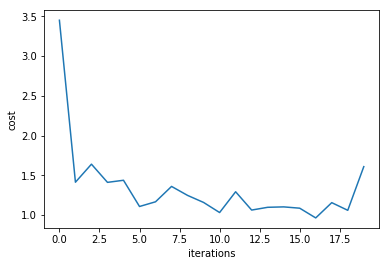

In [5]:
# topo = [400, 400, 200, 50, 10]
topo = [400, 300, 50, 10]
learning_rate = 0.1
iterations = 2000
batch_size = 50
optimize = ryan_gd(X_train, Y_train, topo, learning_rate, iterations, batch_size)

In [6]:
softmax_prob, predictions, accuracy = ryan_softmax_predict(X_train, Y_train1, optimize)
print('Train accuracy: ' + str(accuracy))
softmax_prob, predictions, accuracy = ryan_softmax_predict(X_test, Y_test, optimize)
print('Oprimize Test accuracy: ' + str(accuracy))

Train accuracy: 0.979142857143
Oprimize Test accuracy: 0.910666666667
